In [1]:
# Importing the required modules
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.3 MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import pickle
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [3]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/PW22RBA01 Capstone Project/Phase2/AP Data Analysis/With Indices/NDWI/Cleaned_Soil.csv')
# Importing the dataset
# df = pd.read_csv('Cleaned_Soil.csv')

Mounted at /content/drive


In [4]:
# Obtaining data specific to Anantapur

In [5]:
df = df[df['District'] == 'Prakasam']
df.head()

,Unnamed: 0,Latitude,Longitude,District,Mandal,Village,SoilType,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,NDVI,ARVI,EVI,GCI,NDWI,Crop
2556,2559,15.49,79.5,Prakasam,Kanigiri,Baduguleru,Red,8.31,0.11,0.20,10.71,118.0,1029.0,180.0,4.54,0.76,0.63,1.96,0.62,8.60,0.011788,0.01074,0.111391,0.048773,-0.023806,Cotton
2557,2560,15.49,79.5,Prakasam,Kanigiri,Baduguleru,Red,6.65,0.08,0.12,12.38,75.0,327.0,126.0,2.69,0.58,0.52,15.92,0.60,2.48,0.011788,0.01074,0.111391,0.048773,-0.023806,Cotton
2558,2561,15.49,79.5,Prakasam,Kanigiri,Baduguleru,Red,6.74,0.05,0.13,3.46,64.0,381.0,137.0,2.14,0.26,0.46,10.92,0.66,15.36,0.011788,0.01074,0.111391,0.048773,-0.023806,Cotton
2559,2562,15.49,79.5,Prakasam,Kanigiri,Baduguleru,Red,6.31,0.03,0.16,2.82,129.0,445.0,124.0,2.33,0.18,0.44,7.72,0.62,16.22,0.011788,0.01074,0.111391,0.048773,-0.023806,Cotton
2560,2563,15.49,79.5,Prakasam,Kanigiri,Baduguleru,Red,8.60,0.09,0.09,4.74,62.0,451.0,163.0,2.93,0.24,0.49,0.92,0.28,4.76,0.011788,0.01074,0.111391,0.048773,-0.023806,Cotton


In [6]:
# Dropping unnecessary columns
df = df.drop(['Unnamed: 0', 'Latitude', 'Longitude', 'District', 'Mandal', 'Village', 'ARVI', 'NDVI', 'GCI', 'NDWI'], axis = 1)
df.describe()

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,EVI
count,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000
mean,7.689732,0.334247,0.367505,12.356082,201.072165,1851.701031,413.552577,18.865711,0.530144,1.198804,10.746969,1.190186,11.690330,0.124027
std,1.100884,1.313235,0.275873,10.092348,172.494236,1443.287141,372.891704,58.008623,0.570159,1.293075,10.337956,0.691945,5.422488,0.055346
min,4.650000,0.010000,0.010000,1.030000,22.000000,67.000000,17.000000,0.850000,0.030000,0.100000,0.040000,0.060000,0.010000,0.028862
25%,6.800000,0.070000,0.160000,5.500000,99.000000,485.000000,118.000000,2.670000,0.270000,0.400000,3.840000,0.670000,8.100000,0.110385
50%,8.180000,0.140000,0.310000,9.470000,148.000000,1776.000000,296.000000,5.040000,0.380000,0.770000,6.650000,1.040000,10.770000,0.116524
75%,8.520000,0.260000,0.490000,16.380000,235.000000,2846.000000,610.000000,13.970000,0.590000,1.510000,14.860000,1.580000,14.040000,0.121630
max,9.600000,25.200000,1.940000,83.720000,1529.000000,6745.000000,2017.000000,1015.650000,8.790000,11.850000,73.160000,4.510000,39.840000,0.507065


In [7]:
# Analysis of SoilType

In [8]:
df.SoilType.unique()

array(['Red', 'Black', 'Paddy'], dtype=object)

In [9]:
df['SoilType'] = df['SoilType'].replace('Black', 'Black Soil')
df['SoilType'] = df['SoilType'].replace('Red', 'Red Soil')
df = df[df['SoilType'] != 'Paddy']
df.SoilType.unique()

array(['Red Soil', 'Black Soil'], dtype=object)

In [10]:
soilCount = dict(df['SoilType'].value_counts())
soilCount

{'Black Soil': 82, 'Red Soil': 402}

<BarContainer object of 2 artists>

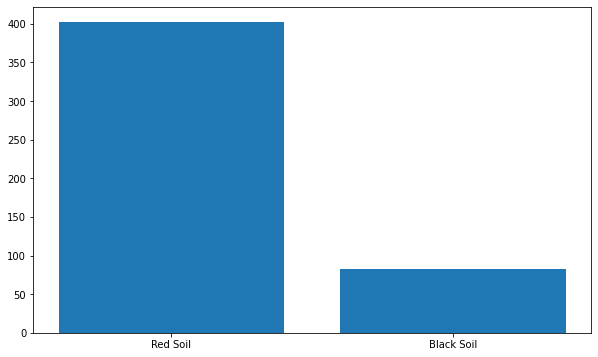

In [11]:
soilType = soilCount.keys()
soilCounts = soilCount.values()
plt.bar(soilType, soilCounts)

In [12]:
# Analysis of Crops grown 

In [13]:
df.Crop.unique()

array(['Cotton', 'Cowpea', 'Paddy', 'Pigeonpea', 'Green gram', 'Cow pea',
       'Tobacco', 'Maize', 'Blackgram', 'Chilli', 'Prawns', 'chickpea'],
      dtype=object)

In [14]:
df['Crop'].value_counts()

Cowpea        201
Cotton         87
Paddy          82
Pigeonpea      45
Tobacco        33
Blackgram      11
Maize          10
chickpea        5
Green gram      3
Prawns          3
Chilli          2
Cow pea         2
Name: Crop, dtype: int64

CowPea    203
Cotton     87
Paddy      82
Name: Crop, dtype: int64


<BarContainer object of 3 artists>

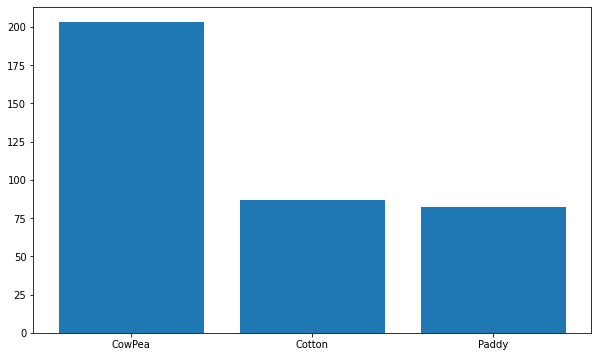

In [15]:
df['Crop'] = df['Crop'].replace('Pigeonpea', 'PigeonPea')
df['Crop'] = df['Crop'].replace(['Cow pea', 'Cowpea'], 'CowPea')
df = df[(df['Crop'] != 'Prawns') & (df['Crop'] != 'Chilli') & (df['Crop'] != 'Green gram') & (df['Crop'] != 'chickpea') & (df['Crop'] != 'Maize') & (df['Crop'] != 'Blackgram') & (df['Crop'] != 'Tobacco') & (df['Crop'] != 'PigeonPea')]

print(df['Crop'].value_counts())
cropCount = dict(df['Crop'].value_counts())
cropType = cropCount.keys()
cropCounts = cropCount.values()
plt.bar(cropType, cropCounts)

In [16]:
# Getting rid of features that have a high correlation among one another

In [17]:
cor_matrix = df.corr()
cor_matrix

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,EVI
pH,1.000000,0.225520,0.627646,0.145641,0.349761,0.710387,0.644894,0.306670,0.121496,0.562174,0.048194,0.365111,-0.196076,0.010625
EC,0.225520,1.000000,0.180770,0.106842,0.269661,0.134513,0.266220,0.883446,0.047044,0.671055,0.084508,0.143672,-0.001015,0.019840
OC,0.627646,0.180770,1.000000,0.347283,0.473994,0.553400,0.684945,0.280316,0.255104,0.634237,0.276063,0.522492,0.112950,-0.053753
P,0.145641,0.106842,0.347283,1.000000,0.496825,0.023922,0.320879,0.213843,0.198732,0.353209,0.439109,0.357966,0.056772,-0.005151
K,0.349761,0.269661,0.473994,0.496825,1.000000,0.147653,0.296714,0.273834,0.129357,0.456390,0.101086,0.301687,0.089939,-0.063067
Ca,0.710387,0.134513,0.553400,0.023922,0.147653,1.000000,0.659068,0.243673,0.036824,0.371171,0.096660,0.403835,0.007595,-0.009591
Mg,0.644894,0.266220,0.684945,0.320879,0.296714,0.659068,1.000000,0.468273,0.143484,0.647208,0.458539,0.718345,0.050831,-0.041033
S,0.306670,0.883446,0.280316,0.213843,0.273834,0.243673,0.468273,1.000000,0.098609,0.752408,0.276360,0.336935,0.016358,0.077496
Zn,0.121496,0.047044,0.255104,0.198732,0.129357,0.036824,0.143484,0.098609,1.000000,0.191370,0.127318,0.272886,0.083235,0.045831
B,0.562174,0.671055,0.634237,0.353209,0.456390,0.371171,0.647208,0.752408,0.191370,1.000000,0.284794,0.454291,-0.028914,-0.030038


In [18]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.5)]
print('Columns to be dropped : ', to_drop)

Columns to be dropped :  ['OC', 'Ca', 'Mg', 'S', 'B', 'Cu']


In [19]:
df = df.drop(to_drop, axis = 1)
print('Columns taken into consideration : ', list(df.columns))

Columns taken into consideration :  ['SoilType', 'pH', 'EC', 'P', 'K', 'Zn', 'Fe', 'Mn', 'EVI', 'Crop']


In [20]:
# Separating the dependent and independent variables
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [21]:
# Encoding SoilType as it is a categorical variable
X = pd.get_dummies(X, prefix='', prefix_sep='')
print(X.head(1))
print(y.head(1))
X = X.values
y = y.values

        pH    EC      P      K    Zn    Fe   Mn       EVI  Black Soil  Red Soil
2556  8.31  0.11  10.71  118.0  0.76  1.96  8.6  0.111391           0         1
2556    Cotton
Name: Crop, dtype: object


In [22]:
# Standardizing the independent variables using Feature Scaling
sc = StandardScaler()
X[:, 0:8] = sc.fit_transform(X[:, 0:8])

In [23]:
# Splitting the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify=y)

# SMOTE: Synthetic Minority Over-sampling Technique

In [24]:
# Separating the dependent and independent variables
df = df.drop(['SoilType'], axis=1)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
smote = SMOTE()
X, y = smote.fit_resample(X, y)

In [25]:
# Standardizing the independent variables using Feature Scaling
sc2 = StandardScaler()
X[:, :] = sc2.fit_transform(X[:, :])

In [26]:
# Splitting the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify=y)

# K-Nearest Neighbors Classifier

In [27]:
clf1 = KNeighborsClassifier(weights='distance')
clf1.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

In [28]:
y_test_pred = clf1.predict(X_test)
y_train_pred = clf1.predict(X_train)
AC1_train = accuracy_score(y_train, y_train_pred)
AC1_test = accuracy_score(y_test, y_test_pred)

In [29]:
print('Training Accuracy: ', AC1_train)
print('Testing Accuracy: ', AC1_test)

Training Accuracy:  1.0
Testing Accuracy:  0.7450980392156863


In [30]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf1, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 71.45 %
Standard Deviation: 5.12 %


# Decision Tree Classifier

In [31]:
clf2 = DecisionTreeClassifier(random_state=0)
clf2.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [32]:
y_test_pred = clf2.predict(X_test)
y_train_pred = clf2.predict(X_train)
AC2_train = accuracy_score(y_train, y_train_pred)
AC2_test = accuracy_score(y_test, y_test_pred)

In [33]:
print('Training Accuracy: ', AC2_train)
print('Testing Accuracy: ', AC2_test)

Training Accuracy:  1.0
Testing Accuracy:  0.7124183006535948


In [34]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf2, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 68.19 %
Standard Deviation: 3.87 %


# Random Forest Classifier

In [35]:
clf3_3 = RandomForestClassifier(random_state=0)
clf3_3.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [36]:
y_test_pred = clf3_3.predict(X_test)
y_train_pred = clf3_3.predict(X_train)
AC3_train = accuracy_score(y_train, y_train_pred)
AC3_test = accuracy_score(y_test, y_test_pred)

In [37]:
print('Training Accuracy: ', AC3_train)
print('Testing Accuracy: ', AC3_test)

Training Accuracy:  1.0
Testing Accuracy:  0.7908496732026143


In [38]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf3_3, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 78.70 %
Standard Deviation: 8.00 %


In [39]:
pickle.dump(clf3_3, open('Prakasam_model.pkl', 'wb'))
pickle.dump(sc2, open('Prakasam_scaler.pkl', 'wb'))

# XGBoost

In [40]:
clf4_4 = HistGradientBoostingClassifier(random_state=0)
clf4_4.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=0)

In [41]:
y_test_pred = clf4_4.predict(X_test)
y_train_pred = clf4_4.predict(X_train)
AC4_train = accuracy_score(y_train, y_train_pred)
AC4_test = accuracy_score(y_test, y_test_pred)

In [42]:
print('Training Accuracy: ', AC4_train)
print('Testing Accuracy: ', AC4_test)

Training Accuracy:  1.0
Testing Accuracy:  0.7777777777777778


In [43]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf4_4, X = X_train, y = y_train, cv = 10)

In [44]:
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 78.94 %
Standard Deviation: 9.03 %


In [45]:
pickle.dump(clf4_4, open('Prakasam_model.pkl', 'wb'))
pickle.dump(sc2, open('Prakasam_scaler.pkl', 'wb'))

# Multi-layer Perceptron Classifier

In [46]:
clf5 = MLPClassifier(random_state=0, learning_rate= 'adaptive')
clf5.fit(X_train, y_train)

MLPClassifier(learning_rate='adaptive', random_state=0)

In [47]:
y_test_pred = clf5.predict(X_test)
y_train_pred = clf5.predict(X_train)
AC5_train = accuracy_score(y_train, y_train_pred)
AC5_test = accuracy_score(y_test, y_test_pred)

In [48]:
print('Training Accuracy: ', AC5_train)
print('Testing Accuracy: ', AC5_test)

Training Accuracy:  0.8004385964912281
Testing Accuracy:  0.6928104575163399


In [49]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf5, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 66.87 %
Standard Deviation: 6.98 %


# Catboost

In [50]:
from catboost import CatBoostClassifier, Pool, cv

model = CatBoostClassifier(iterations=100, depth=2, learning_rate=1, loss_function='MultiClass', verbose=True)
model.fit(X_train, y_train)

model.calc_feature_statistics(X_train, y_train, feature=1, plot=True)

train_data = Pool(data=X_train, label=y_train)
model.get_feature_importance(train_data)

#Cross-Validation
cv_dataset = Pool(data=X_train, label=y_train)
params = {"iterations": 100, "depth": 2, "loss_function": "MultiClass", "verbose": False}
scores = cv(cv_dataset, params, fold_count=5, plot="True")

model = CatBoostClassifier(loss_function='MultiClass')
grid = {'learning_rate': [0.03, 0.1], 'depth': [4, 6, 10]}
grid_search_result = model.grid_search(grid, X=X_train, y=y_train, cv=3, plot=True)

model.score(X_test, y_test)

# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

0:	learn: 0.8572990	total: 47ms	remaining: 4.66s
1:	learn: 0.7990627	total: 47.9ms	remaining: 2.35s
2:	learn: 0.7406366	total: 48.6ms	remaining: 1.57s
3:	learn: 0.6978396	total: 49.4ms	remaining: 1.19s
4:	learn: 0.6786825	total: 50.2ms	remaining: 954ms
5:	learn: 0.6573802	total: 51ms	remaining: 800ms
6:	learn: 0.6360254	total: 52ms	remaining: 691ms
7:	learn: 0.6318865	total: 52.9ms	remaining: 608ms
8:	learn: 0.6171644	total: 53.9ms	remaining: 545ms
9:	learn: 0.6016934	total: 54.9ms	remaining: 494ms
10:	learn: 0.5840571	total: 55.9ms	remaining: 453ms
11:	learn: 0.5540840	total: 56.9ms	remaining: 418ms
12:	learn: 0.5399957	total: 57.8ms	remaining: 387ms
13:	learn: 0.5294459	total: 58.8ms	remaining: 361ms
14:	learn: 0.5081633	total: 59.8ms	remaining: 339ms
15:	learn: 0.4931795	total: 60.8ms	remaining: 319ms
16:	learn: 0.4762361	total: 61.8ms	remaining: 302ms
17:	learn: 0.4727919	total: 62.8ms	remaining: 286ms
18:	learn: 0.4678101	total: 63.8ms	remaining: 272ms
19:	learn: 0.4623232	total: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.7869253909
bestIteration = 99

Training on fold [1/5]

bestTest = 0.7592746265
bestIteration = 99

Training on fold [2/5]

bestTest = 0.7595596441
bestIteration = 99

Training on fold [3/5]

bestTest = 0.7800141948
bestIteration = 99

Training on fold [4/5]

bestTest = 0.7779875169
bestIteration = 99



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
2:	learn: 0.9629326	total: 7.5ms	remaining: 2.49s
3:	learn: 0.9341172	total: 9.42ms	remaining: 2.35s
4:	learn: 0.9041514	total: 11.2ms	remaining: 2.23s
5:	learn: 0.8778857	total: 13.1ms	remaining: 2.17s
6:	learn: 0.8491854	total: 14.9ms	remaining: 2.12s
7:	learn: 0.8323866	total: 16.8ms	remaining: 2.08s
8:	learn: 0.8163839	total: 18.7ms	remaining: 2.06s
9:	learn: 0.7989187	total: 20.5ms	remaining: 2.03s
10:	learn: 0.7837759	total: 22.3ms	remaining: 2.01s
11:	learn: 0.7718511	total: 24.1ms	remaining: 1.99s
12:	learn: 0.7587955	total: 26ms	remaining: 1.97s
13:	learn: 0.7467968	total: 27.8ms	remaining: 1.96s
14:	learn: 0.7355537	total: 29.7ms	remaining: 1.95s
15:	learn: 0.7219573	total: 31.5ms	remaining: 1.94s
16:	learn: 0.7121349	total: 33.3ms	remaining: 1.93s
17:	learn: 0.7053640	total: 35.1ms	remaining: 1.92s
18:	learn: 0.6971788	total: 37ms	remaining: 1.91s
19:	learn: 0.6864294	total: 38.8ms	remaining: 1.9s
20:	learn: 0.6780621	total: